### QC of 10X data on reprogramming OPC

Workflow: 1. General QC from filtred matrices. 2. integrate data with scvi

Use cell2tcr_env

## QC

In [1]:
import scanpy as sc
import anndata as ad
import os
import datetime

In [2]:
dirs = os.listdir("dt/")
adatas = {}

for dir_name in dirs:
    dir_path = os.path.join("dt/", dir_name)
    if os.path.isdir(dir_path):  # Check if it's a directory
        if dir_path.endswith("bc_matrix"): 
            # Read 10X data
            sample_adata = sc.read_10x_mtx(dir_path)
            sample_adata.var_names_make_unique()
            cond = dir_name.split("_")[0]
            sample_adata.obs['condition'] = cond
            
            adatas[cond] = sample_adata

In [3]:
adatas

{'OPC': AnnData object with n_obs × n_vars = 2837 × 25627
     obs: 'condition'
     var: 'gene_ids', 'feature_types',
 'TF': AnnData object with n_obs × n_vars = 7975 × 25627
     obs: 'condition'
     var: 'gene_ids', 'feature_types',
 'BMP4': AnnData object with n_obs × n_vars = 10169 × 25627
     obs: 'condition'
     var: 'gene_ids', 'feature_types',
 'primarySC': AnnData object with n_obs × n_vars = 12479 × 25627
     obs: 'condition'
     var: 'gene_ids', 'feature_types'}

In [4]:
adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()
print(adata.obs["sample"].value_counts())
adata

sample
primarySC    12479
BMP4         10169
TF            7975
OPC           2837
Name: count, dtype: int64


/Users/yy8/miniconda/envs/oor/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 33460 × 25627
    obs: 'condition', 'sample'

In [5]:
adata.var["mt"] = adata.var_names.str.startswith("Mt-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("Rps", "Rpl"))

In [6]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo"], inplace=True, log1p=True
)

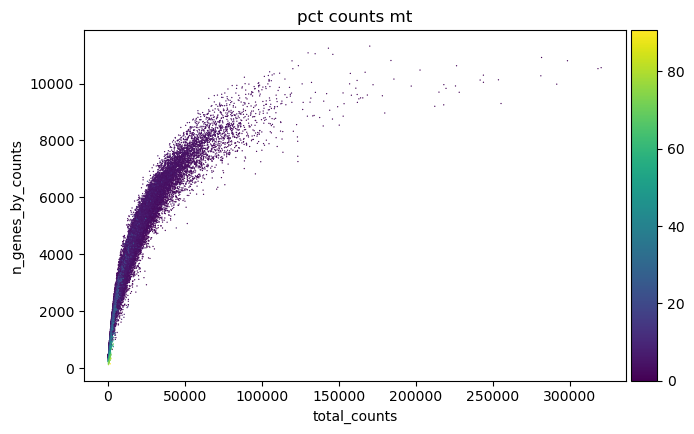

In [7]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [8]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

In [9]:
sc.pp.scrublet(adata, batch_key="sample")

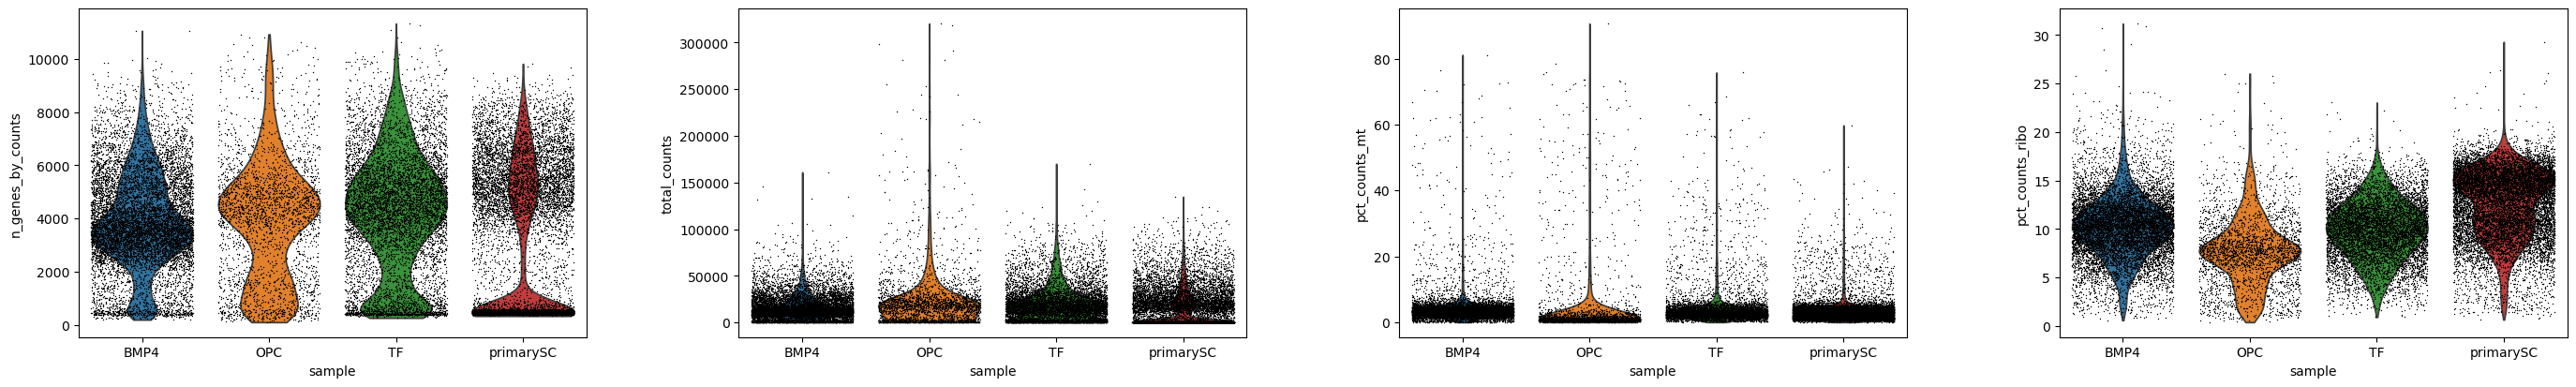

In [10]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo'],
             jitter=0.4, groupby = 'sample')

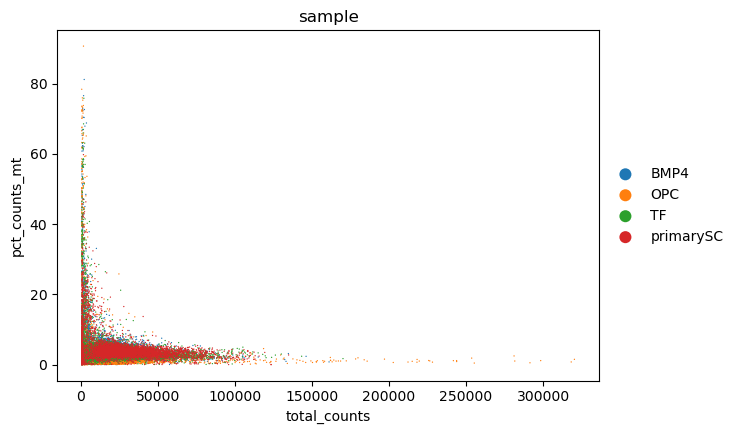

In [11]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color="sample")

In [12]:
adata.write_h5ad("dt_out/0_preprocessing/combined_adata_from_filtered_h5_before_qc.h5ad")

quick filter based on mt and total counts and genes

In [13]:
adata.obs["outlier_mt"] = adata.obs.pct_counts_mt > 20
adata.obs["outlier_total"] = adata.obs.total_counts > 100000
adata.obs["outlier_ngenes"] = adata.obs.n_genes_by_counts > 10000

print(
    "%u cells with high %% of mitochondrial genes"
    % (sum(adata.obs["outlier_mt"]))
)
print("%u cells with large total counts" % (sum(adata.obs["outlier_total"])))
print("%u cells with large number of genes" % (sum(adata.obs["outlier_ngenes"])))

adata = adata[~adata.obs["outlier_mt"], :]
adata = adata[~adata.obs["outlier_total"], :]
adata = adata[~adata.obs["outlier_ngenes"], :]

681 cells with high % of mitochondrial genes
157 cells with large total counts
39 cells with large number of genes


In [14]:
adata.obs['predicted_doublet'].value_counts()

predicted_doublet
False    32617
True         2
Name: count, dtype: int64

In [15]:
adata = adata[~adata.obs["predicted_doublet"], :]

## Normalisation & HVG

In [16]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

/var/folders/lb/xhq_wzhs30l78s_s99z52_jh0000gq/T/ipykernel_97152/1526851425.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()


In [17]:
sc.pp.highly_variable_genes(adata, n_top_genes=3000, batch_key="sample")

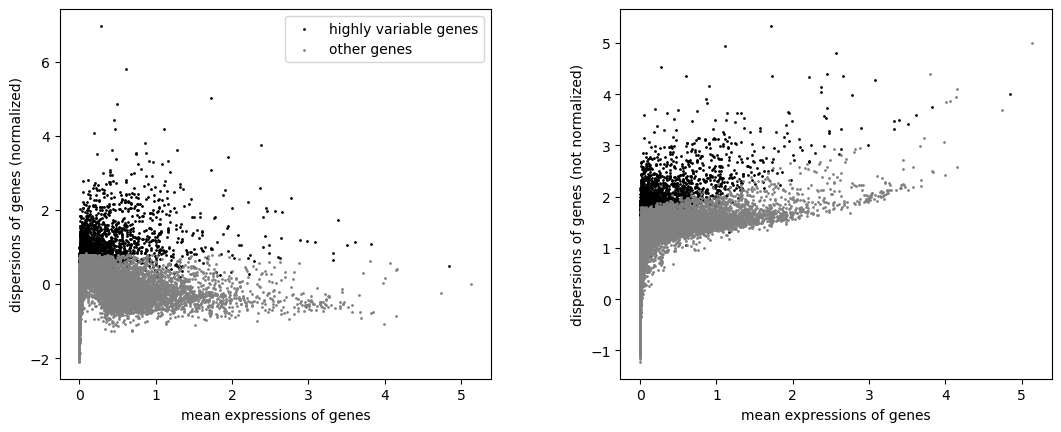

In [18]:
sc.pl.highly_variable_genes(adata)

In [19]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

In [20]:
sc.tl.pca(adata)

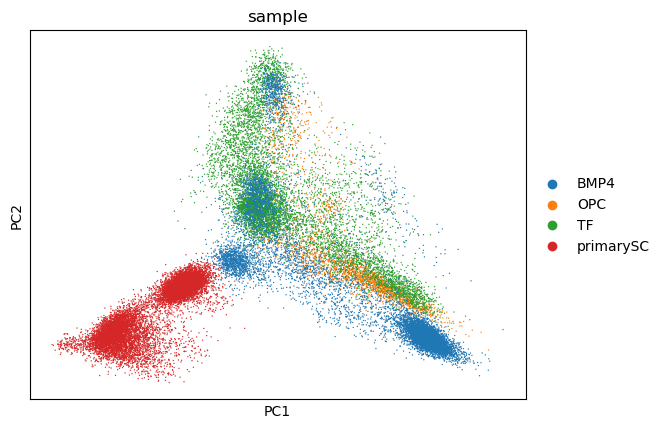

In [21]:
sc.pl.pca(adata, color = "sample")

In [22]:
sc.pp.neighbors(adata)

/Users/yy8/miniconda/envs/oor/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
sc.tl.umap(adata)

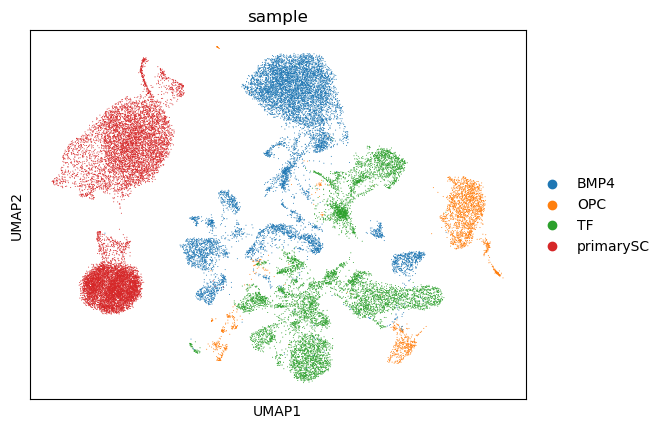

In [24]:
sc.pl.umap(
    adata,
    color="sample",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

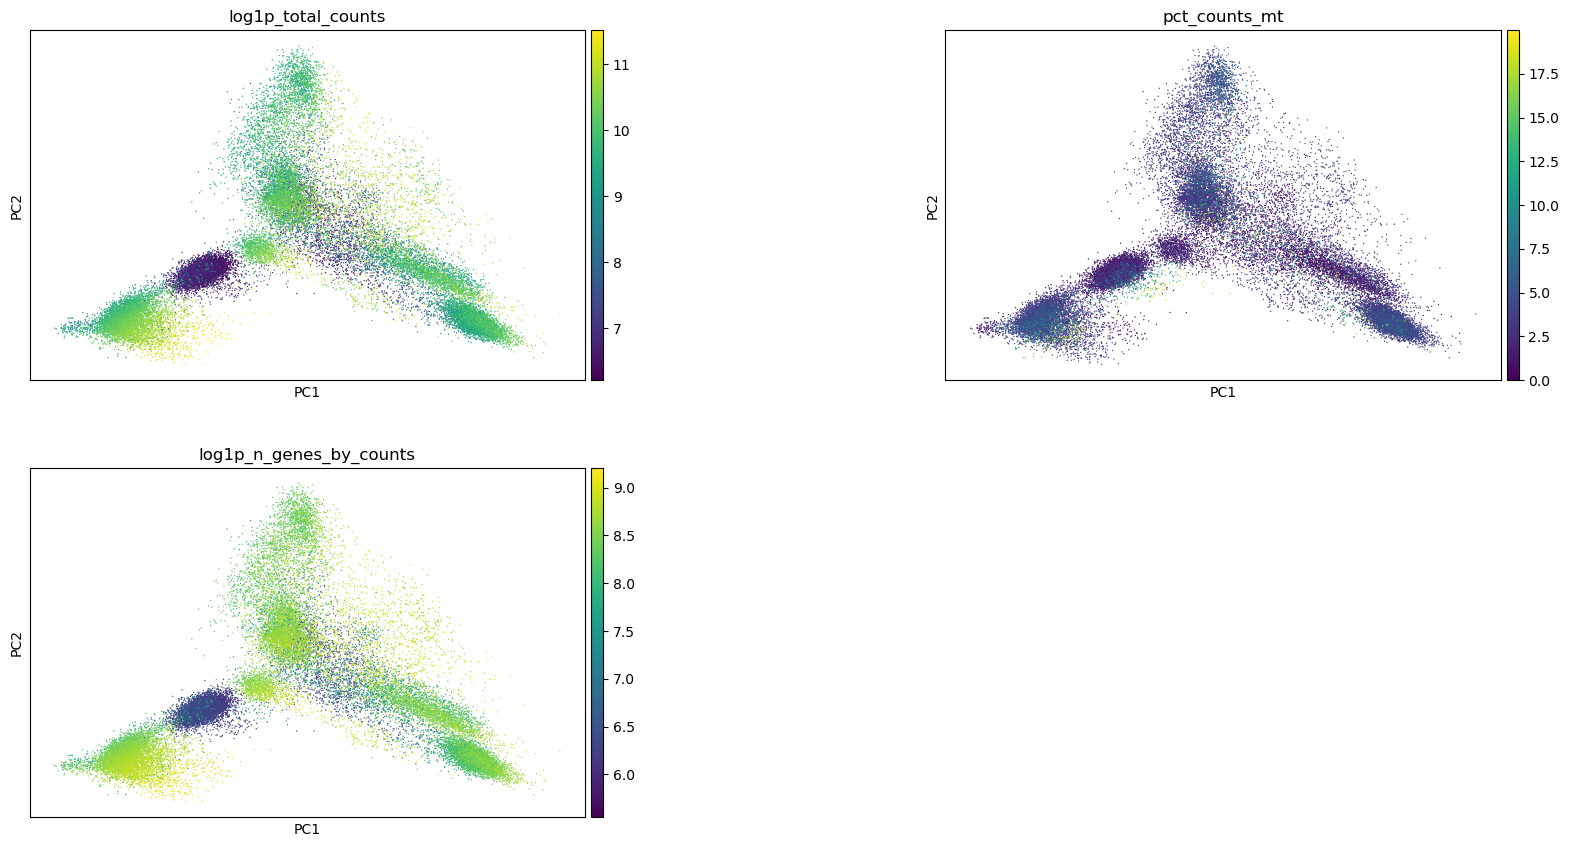

In [25]:
sc.pl.pca(
    adata,
    color=["log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
)

In [26]:
adata.write_h5ad("dt_out/0_preprocessing/combined_adata_from_filtered_h5_withBasicQCregressout.h5ad")

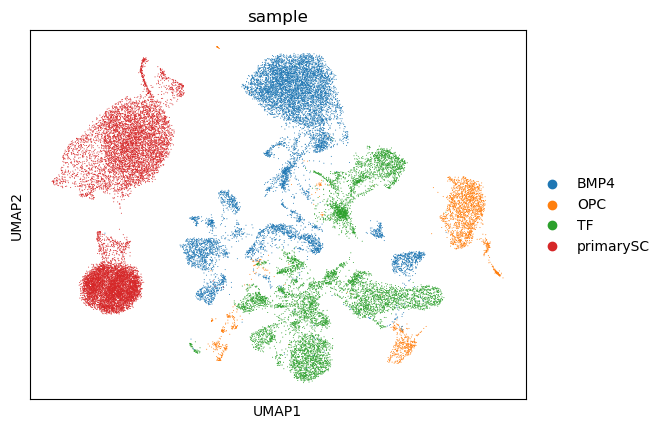

In [27]:
sc.pl.umap(
    adata,
    color="sample",
    # Setting a smaller point size to get prevent overlap
    size=2,
)